In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit

In [13]:
def extraccion(datos):
    t = datos[2:].T[0] # segundos
    lista_pos=[]
    lista_bien  = []
    for i in range(1, len(datos[0]), 2):
        xy = []
        for j in datos:
            if np.isnan(j[i]) == False: 
                xy.append([j[i], j[i+1]])
        xy = np.array(xy)
        lista_pos.append(xy)
    for part in lista_pos:
        np.stack(part)
        lista_bien.append(pixel_a_micron(part.T)*1e-6)
    return t, lista_bien

def MSD(x, y, err_d):
    suma=0
    suma_err = 0
    for n in range(len(x)):
        suma+=(x[n]-x[0])**2+(y[n]-y[0])**2
        suma_err += x[n]-x[0] + y[n]-y[0]
    err_MSD = 2*err_d*np.sqrt(suma + suma_err**2)/len(x)
    MSD = suma/len(x)
    return MSD, err_MSD

def MSD_data(lista_bien, err_d):
    lista_MSD = []
    err_lista_MSD = []
    for n, part in enumerate(lista_bien):
        x = part[0]
        y = part[1]
        part_MSD = []
        err_part_MSD = []
        for i in range(len(x)):    
            msd, err = MSD(x[:i+1], y[:i+1], err_d)
            part_MSD.append(msd)
            err_part_MSD.append(err)
        lista_MSD.append(part_MSD)
        err_lista_MSD.append(err_part_MSD)
    return lista_MSD, err_lista_MSD

def promedio(lista_MSD, err_listaMSD):
    MSD_promedio = []
    err_promedio = []
    for n in range(len(lista_MSD[0])): 
        val = 0
        sigma = 0
        for disp in lista_MSD:
            val += disp[n]
        for e in err_listaMSD:
            sigma += e[n]**2
        MSD_promedio.append(val/len(lista_MSD))
        err_promedio.append(np.sqrt(sigma)/len(err_listaMSD))
    return MSD_promedio, err_promedio

def lineal(x, a, b):
    return a*x + b

def viscosidad(m, R, T, err_m, err_R, err_T):
    neff = 2*1.38*1e-23*T/(3*np.pi*R*m)
    err_neff = (2*1.38*1e-23/(3*np.pi))*np.sqrt((err_T/(R*m))**2 + (err_R*(T/(R*m))**2)**2 + (err_m*T/(R*(m**2)))**2) # propagación de errores
    return neff, err_neff


def fuerza_V(R, neff, v, err_R, err_n, err_v):
    F = 6*np.pi*neff*R*v
    err_F = 6*np.pi*np.sqrt((R*v*err_n)**2 + (neff*v*err_R)**2 + (neff*R*err_v)**2)
    return F, err_F

def pixel_a_micron(pix): # toma píxeles devuelve micrones
    escala = 10/106.04
    micro = pix*escala
    return micro

def celsius_a_k(g):
    return g+273.15

In [14]:
datos_aguaMQ = np.genfromtxt('Mediciones/browniano solo agua pixel.txt', delimiter=',')
datos_1_en_2 = np.genfromtxt('Mediciones/browniano 1 en 2 pixel.txt', delimiter=',')

t_aguaMQ, lista_aguaMQ = extraccion(datos_aguaMQ)
t_1_en_2, lista_1_en_2 = extraccion(datos_1_en_2)

err_t_MQ = np.ones(len(t_aguaMQ))/9.19 # segundos
err_t_12 = np.ones(len(t_1_en_2))/9.19 # segundos
err_d = pixel_a_micron(12.5/4)*1e-6

lista_tiempos = [t_aguaMQ, t_1_en_2]
err_lista_tiempos = [err_t_MQ, err_t_12]

In [15]:
lista_MSD_aguaMQ, err_MSD_MQ = MSD_data(lista_aguaMQ, err_d)
lista_MSD_1_en_2, err_MSD_12 = MSD_data(lista_1_en_2, err_d)

MSD_prom_aguaMQ, err_pro_MQ = promedio(lista_MSD_aguaMQ, err_MSD_MQ)
MSD_prom_1_en_2, err_pro_12 = promedio(lista_MSD_1_en_2, err_MSD_12)



In [16]:
popt_lin, pcov_lin = curve_fit(lineal, t_aguaMQ[:len(MSD_prom_aguaMQ)], MSD_prom_aguaMQ, p0=[0, 0])
m_amq, b_amq = popt_lin
perr_lin = np.sqrt(np.diag(pcov_lin))
err_m_amq, err_b_amq = perr_lin

# R^2 lineal:
res_lin = MSD_prom_aguaMQ - lineal(t_aguaMQ[:len(MSD_prom_aguaMQ)], *popt_lin)
ss_res_lin = np.sum(res_lin**2)
ss_tot_lin = np.sum((MSD_prom_aguaMQ - np.mean(MSD_prom_aguaMQ))**2)
r_cuadrado_lin_amq = 1 - (ss_res_lin / ss_tot_lin)

print(f'Ajuste lineal agua MQ m*x + b\nm = {m_amq} +- {err_m_amq}\nb1 = {b_amq} +- {err_b_amq}\nR^2 = {r_cuadrado_lin_amq}\n')

popt_lin, pcov_lin = curve_fit(lineal, t_1_en_2[:len(MSD_prom_1_en_2)], MSD_prom_1_en_2, p0=[0, 0])
m_12, b_12 = popt_lin
perr_lin = np.sqrt(np.diag(pcov_lin))
err_m_12, err_b_12 = perr_lin

# R^2 lineal:
res_lin = MSD_prom_1_en_2 - lineal(t_1_en_2[:len(MSD_prom_1_en_2)], *popt_lin)
ss_res_lin = np.sum(res_lin**2)
ss_tot_lin = np.sum((MSD_prom_1_en_2 - np.mean(MSD_prom_1_en_2))**2)
r_cuadrado_lin_12 = 1 - (ss_res_lin / ss_tot_lin)

print(f'Ajuste lineal 1 en 2 m*x + b\nm = {m_12} +- {err_m_12}\nb1 = {b_12} +- {err_b_12}\nR^2 = {r_cuadrado_lin_12}\n')

Ajuste lineal agua MQ m*x + b
m = 1.21961137548347e-13 +- 1.2765361388551417e-15
b1 = 6.525912636103536e-13 +- 3.317544593269395e-14
R^2 = 0.9312386845199763

Ajuste lineal 1 en 2 m*x + b
m = 3.398496227534577e-13 +- 1.4441515039635195e-15
b1 = -2.6817601274906527e-13 +- 3.469688246852612e-14
R^2 = 0.9888754714529063



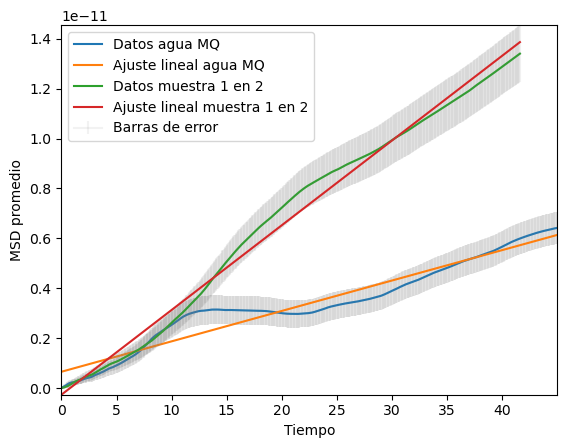

In [17]:
fig, ax = plt.subplots()

# agua MQ:
x = np.linspace(t_aguaMQ[0], t_aguaMQ[:len(MSD_prom_aguaMQ)][-1], 1000)
y_fit_lin = lineal(x, m_amq, b_amq)

ax.errorbar(t_aguaMQ[:len(MSD_prom_aguaMQ)], MSD_prom_aguaMQ, err_pro_MQ, alpha = 0.1, color='gray', label='Barras de error')
ax.plot(t_aguaMQ[:len(MSD_prom_aguaMQ)], MSD_prom_aguaMQ, label='Datos agua MQ')
ax.plot(x, y_fit_lin, label='Ajuste lineal agua MQ')

# 1 en 2:
x = np.linspace(t_1_en_2[0], t_1_en_2[:len(MSD_prom_1_en_2)][-1], 1000)
y_fit_lin = lineal(x, m_12, b_12)

ax.errorbar(t_1_en_2[:len(MSD_prom_1_en_2)], MSD_prom_1_en_2, err_pro_12, alpha = 0.1, color='gray')
ax.plot(t_1_en_2[:len(MSD_prom_1_en_2)], MSD_prom_1_en_2, label='Datos muestra 1 en 2')
ax.plot(x, y_fit_lin, label='Ajuste lineal muestra 1 en 2')

ax.set_xlabel('Tiempo')
ax.set_ylabel('MSD promedio')
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.legend()

In [18]:
radio_px = 50/2
radio = pixel_a_micron(radio_px)*1e-6 # el 1e-6 lo pasa a metros para tener el neff en unidades razonables

T_celsius = 25.5
T = celsius_a_k(T_celsius)

neff_amq, nerr_amq = viscosidad(m_amq, radio, T, err_m_amq, err_d, 0.1)
Fuerza_v_amq, err_F_amq = fuerza_V(radio, neff_amq, 8*1e-6, err_d, nerr_amq, 1*1e-6)

neff_12, nerr_12 = viscosidad(m_12, radio, T, err_m_12, err_d, 0.1)
Fuerza_v_12, err_F_12 = fuerza_V(radio, neff_12, 5*1e-6, err_d, nerr_12, 1*1e-6)

print(f'Agua mQ\nEl coeficiente de viscosidad es: {neff_amq} +- {nerr_amq}\nLa fuerza del láser calculada con estos datos es: {Fuerza_v_amq} +- {err_F_amq}\n')

print(f'Muestra de agua con glicerina:\nEl coeficiente de viscosidad es: {neff_12} +- {nerr_12}\nLa fuerza del láser calculada con estos datos es: {Fuerza_v_12} +- {err_F_12}')
print(Fuerza_v_amq, Fuerza_v_12)

Agua mQ
El coeficiente de viscosidad es: 0.003041646350958008 +- 931021656748.5612
La fuerza del láser calculada con estos datos es: 1.0813595433030416e-12 +- 330.9948091860744

Muestra de agua con glicerina:
El coeficiente de viscosidad es: 0.0010915493916900138 +- 119902746686.55122
La fuerza del láser calculada con estos datos es: 2.4254080181750433e-13 +- 26.64222850827804
1.0813595433030416e-12 2.4254080181750433e-13
